## Loading Packages/Data

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import model_selection

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HWjyghPfBJ_XbtKEaFFIyCTOLEEg__Ij' -O train.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PKA6Qpm2rfZ7Z4ixA5hIrDUlaksvy7Pd' -O validation.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XAsNEeqb8eXvVLNfxj1nlHGJuwu5Ea25' -O test.csv

--2020-07-05 18:18:37--  https://docs.google.com/uc?export=download&id=1HWjyghPfBJ_XbtKEaFFIyCTOLEEg__Ij
Resolving docs.google.com (docs.google.com)... 172.217.193.101, 172.217.193.100, 172.217.193.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.193.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8m0r09fg0p1lein3jbuvbgoc845ttod5/1593973050000/15910814371148022664/*/1HWjyghPfBJ_XbtKEaFFIyCTOLEEg__Ij?e=download [following]
--2020-07-05 18:18:38--  https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8m0r09fg0p1lein3jbuvbgoc845ttod5/1593973050000/15910814371148022664/*/1HWjyghPfBJ_XbtKEaFFIyCTOLEEg__Ij?e=download
Resolving doc-0c-7s-docs.googleusercontent.com (doc-0c-7s-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connecting to doc-0c-7s-docs.googleusercontent.com (doc-0c-7

In [ ]:
# Read datasets into colab
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")
test = pd.read_csv("test.csv")

In [ ]:
True in fakenews.title.isnull()

True

In [ ]:
# Concat all datasets to prepare one full dataset
fakenews = pd.concat([train, validation, test])
fakenews

,id,label,statement,subject,speaker,title,state,party,barely_true,not_true,half_true,mostly_true,lie,context
0,2635.json,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,FALSE,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,7334.json,half-true,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28.0,23.0,38.0,34.0,7.0,a news conference
1263,9788.json,barely-true,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2.0,0.0,0.0,1.0,0.0,"on ABC's ""This Week"""
1264,10710.json,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1.0,0.0,0.0,0.0,0.0,a commentary in The Providence Journal
1265,3186.json,barely-true,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9.0,8.0,10.0,18.0,3.0,a news conference


## Data Exploration and Preparation

This part explores the distributions of important variables and prepares features and labels for machine learning modeling. 

### Missing Data

First, I examined the missing values in the dataset and found that two statements don't have values for all variables, so I dropped those two data entries. I also found that there are some missing values for context (131) and many missing values for title and state (3567 and 2749). Since removing the missing values will greatly reduce the size of training data, I decided to not drop them and fill them with "missing".

In [ ]:
# Summarize missing values in the dataset
fakenews.isna().sum()

id                0
label             0
statement         0
subject           2
speaker           2
title          3567
state          2749
party             2
barely_true       2
not_true          2
half_true         2
mostly_true       2
lie               2
context         131
dtype: int64

In [ ]:
# Remove two data entries without any values for variables
fakenews = fakenews.dropna(subset=['subject'])

# Fill the rest of the missing values with "missing"
fakenews = fakenews.fillna("missing") 

### Features

This part explores the variables in the dataset and examines which of these variables could be use as features. I also conducted feature engineering for certain variables to convert them into features and to prepare them for use in the modeling. 

#### Statement Text

This part examines the "statement" variable in the dataset, which has the texts of statements. To transform this variable into a usable feature, I created a new variable "statement_length" for the lengths of statements. The distribution of "statement_length" shows that while its distribution closely resembles a normal distribution under 500, it has a very high range of distribution that extends to more than 3000. To avoid numerical instability issues, I rescaled "statement_length" to log scale (base e) and its distribution became more like normal distribution curve. 

In [ ]:
# Create new variable 'statement_length'
fakenews['statement_length'] = fakenews['statement'].map(lambda x: len(x))

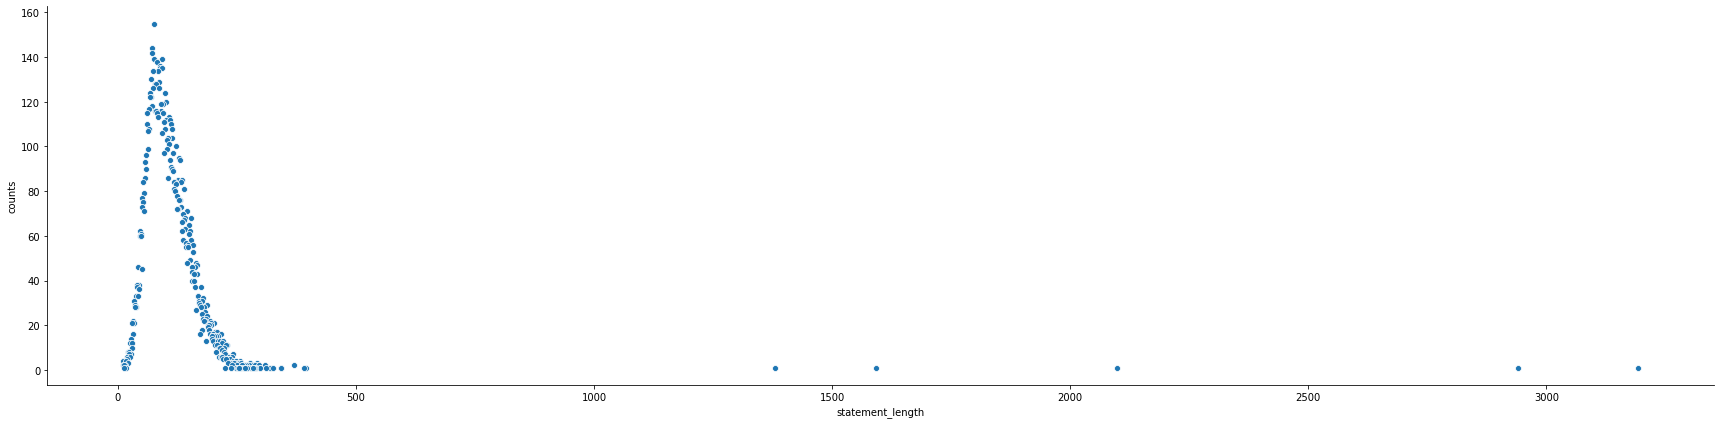

In [ ]:
# Visualize the distribution of 'statement_length' with seaborn
statement_length = fakenews['statement_length'].value_counts().rename_axis('statement_length').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
k = sns.relplot(x = 'statement_length', y = 'counts', kind="scatter", data = statement_length, height=6, aspect=4)

In [ ]:
# Rescale 'statement_length' to log scale (base e) 'statement_length_log'
fakenews['statement_length_log'] = np.log(fakenews["statement_length"])

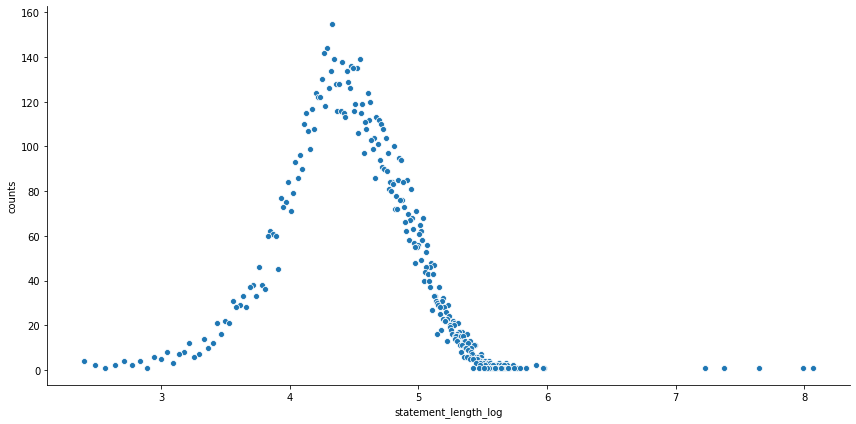

In [ ]:
# Visualize the distribution of 'statement_length_log' with seaborn
statement_length_log = fakenews['statement_length_log'].value_counts().rename_axis('statement_length_log').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
k = sns.relplot(x = 'statement_length_log', y = 'counts', kind="scatter", data = statement_length_log, height=6, aspect=2)

#### Statement Subject

This part examines the "subject" variable in the dataset, which has the subjects of statements. There are 4534 different subjects and the top five most mentioned ones are health care, taxes, education, elections, and immigration. However, a lot of statements included more than one subject. To take this factor into account, I created a new variable "subject_count" for the number of subjects. The distribution of "subject_count" shows that while the great majority of the politicians referred to only 1-3 subjects in their statements, some of them referred to as many as 20 subjects. Both “subject” and “subject_count” variables will be used as features.

In [ ]:
# Distribution of subjects
subject = fakenews['subject'].value_counts().rename_axis('subject').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
subject

,subject,counts
0,health-care,474
1,taxes,356
2,education,309
3,elections,304
4,immigration,303
...,...,...
2243,"congress,diversity,history,population,women",1
2244,"state-budget,state-finances,workers",1
2245,"debt,economy,federal-budget,message-machine-2012",1
2246,"climate-change,education,energy,environment,he...",1


In [ ]:
# Distribution of subject counts
fakenews['subject_count'] = fakenews['subject'].map(lambda x: x.count(",")+1)
fakenews['subject_count'].value_counts()

1     4857
2     3956
3     2325
4      995
5      365
6      145
7       56
8       35
9       22
10      15
11       5
13       3
14       3
12       2
16       2
15       2
20       1
Name: subject_count, dtype: int64

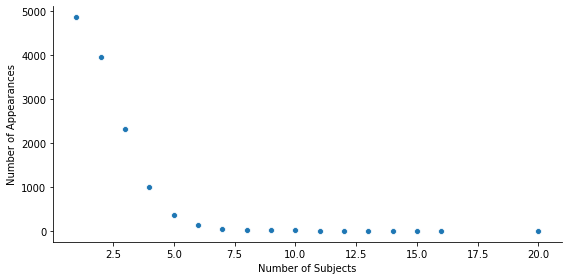

In [ ]:
# Distribution of the counts of subject
fakenews['subject_count'] = fakenews['subject'].map(lambda x: x.count(",")+1)
subject_count = fakenews['subject_count'].value_counts().rename_axis('Number of Subjects').reset_index(name = 'Number of Appearances').sort_values(by='Number of Appearances', ascending = False)
m = sns.relplot(x = 'Number of Subjects', y = 'Number of Appearances', kind="scatter", data = subject_count, height=4, aspect=2)

#### Speaker name

This part examines the "speaker" variable in the dataset, which has the names of speakers. There are in total 1355 speakers in the dataset and the top five speakers are Barack Obama, Donald Trump, Hillary Clinton, Mitt Romney, and John McCain. However, while certain speakers appear many times, the majority of speakers only appear one to two times. Therefore, I decided to not use speaker names as a feature. Moreover, the names of the existing speakers won't have much predictive power for the new speakers which will be added into the future dataset.

In [ ]:
# Speaker names
name = fakenews['speaker'].value_counts().rename_axis('speaker').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
name

,speaker,counts
0,barack-obama,611
1,donald-trump,343
2,hillary-clinton,297
3,mitt-romney,212
4,john-mccain,189
...,...,...
1934,stephen-fincher,1
1933,steven-goldstein,1
1932,james-bell,1
1931,texas-department-transportation,1


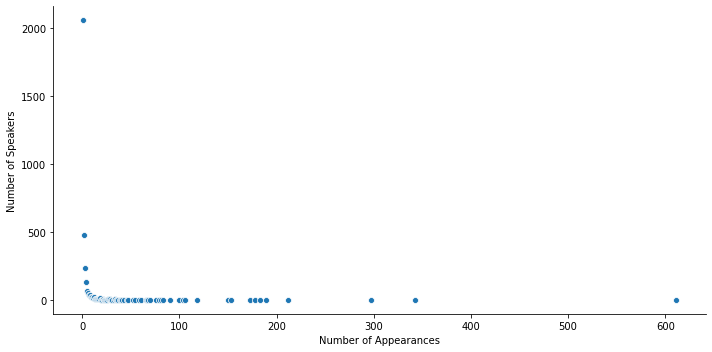

In [ ]:
# Distribution of the counts of speaker names
name_counts = name.groupby('counts', as_index = False).count()
name_counts.columns = ['Number of Appearances', 'Number of Speakers']
m = sns.relplot(x = 'Number of Appearances', y = 'Number of Speakers', kind="scatter", data = name_counts, height=5, aspect=2)

#### Speaker Title

This part examines the "title" variable in the dataset, which has the titles of speakers. The top 20 most frequent titles show that certain titles are classified as different titles just because of uppercase and lowercase, such as "U.S. Senator" and "U.S. senator". After I changed all titles to lower case, the number of unique titles went down from 1356 to 1279. The plot of the distribution of titles shows that the majority of speakers are U.S. Senator, President, and Governor. I will use "title" as a feature because a politician's title might be related to his/her tendency to lie. 


In [ ]:
# Top 20 most frequent speaker titles
title = fakenews['title'].value_counts().rename_axis('title').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
title[0:20]

,title,counts
0,missing,3565
1,President,615
2,U.S. Senator,595
3,Governor,487
4,President-Elect,343
5,U.S. senator,328
6,Presidential candidate,314
7,Former governor,212
8,U.S. Representative,210
9,Senator,193


In [ ]:
print(f"Originally, there are {len(title)} titles")

Originally, there are 1356 titles


In [ ]:
# Change titles to lowercase
fakenews['title'] = fakenews['title'].apply(lambda x: x.lower())

In [ ]:
# Top 20 most frequent cleaned lowercase titles, in contrast to the top 20 uncleaned titles
clean_title = fakenews['title'].value_counts().rename_axis('title').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
clean_title[0:20]

,title,counts
0,missing,3565
1,u.s. senator,923
2,president,615
3,governor,537
4,president-elect,343
5,u.s. representative,340
6,presidential candidate,315
7,state senator,253
8,state representative,224
9,former governor,213


In [ ]:
print(f'After cleaning, there are {len(clean_title)} titles')

After cleaning, there are 1279 titles


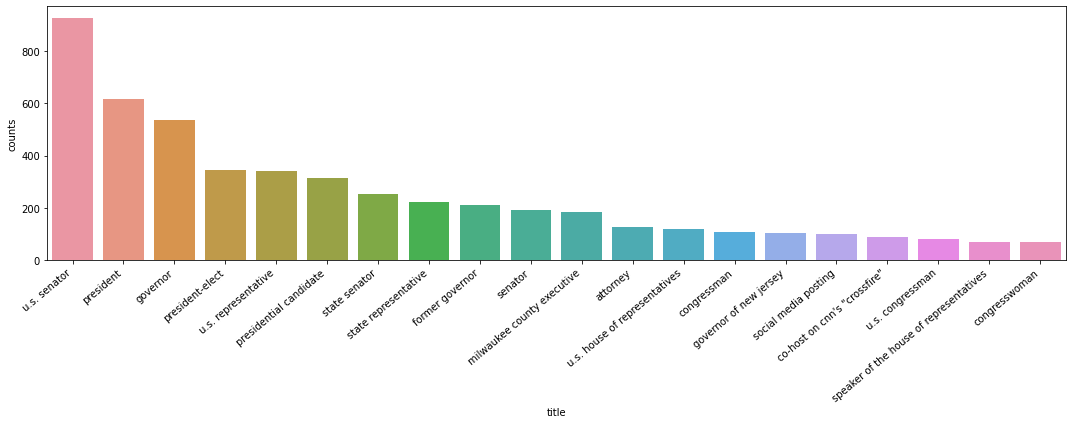

In [ ]:
# Visualize top 20 most frequent speaker titles besides "missing" with seaborn
title_to_visualize = clean_title.loc[clean_title['title']!='missing'].sort_values(by='counts', ascending = False)[0:20]

plt.figure(figsize=(15,6))
l = sns.barplot(x="title", y="counts", data=title_to_visualize)
l.set_xticklabels(l.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

#### Speaker State

This part examines the "state" variable in the dataset, which has the locations of speakers. A close examination of state names shows that some states are classified as different states just because their spelling is different, such as Washington DC and Washington, D.C. Therefore, I created a dictionary to transform differnt spelling of the same states to the same ones. The number of unique values decreased from 86 to 64. I also found that several locations don't belong to the United States, including Russia, China, United Kingdom, and Qatar. I classified them into "other country". The plot of the distribution of states shows that Texas, Florida, Wisconsin, New York and Illinois have the most number of speakers in this dataset. I will use state as a feature because the location of the speaker might be related to his/her tendency to tell the truth.


In [ ]:
# Distribution of states
state = fakenews['state'].value_counts().rename_axis('state').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
state

,state,counts
0,missing,2747
1,Texas,1260
2,Florida,1231
3,Wisconsin,900
4,New York,829
...,...,...
71,"Virginia director, Coalition to Stop Gun Violence",1
70,Washington DC,1
69,Qatar,1
68,Rhode Island,1


In [ ]:
# Examine state names
fakenews['state'].unique()

array(['Texas', 'Virginia', 'Illinois', 'missing', 'Florida', 'Wisconsin',
       'New Jersey', 'Vermont', 'Massachusetts', 'Maryland',
       'Washington, D.C. ', 'Oregon', 'New York', 'Washington, D.C.',
       'California', 'Missouri', 'Rhode Island', 'West Virginia',
       'Arkansas', 'New Hampshire', 'Ohio', 'Georgia', 'Arizona',
       'Wyoming', 'Delaware', 'Kentucky', 'Kansas', 'ohio', 'Colorado',
       'North Carolina', 'New Mexico', 'Illinois ', 'Alaska',
       'South Carolina', 'Minnesota', 'Tennessee', 'Pennsylvania', 'Iowa',
       'Connecticut', 'Louisiana', 'Indiana', 'Florida ', 'Utah',
       'Michigan', 'Oklahoma', 'Nevada', 'Oregon ', 'Virgina', 'Nebraska',
       'Georgia ', 'None', 'Washington D.C.', 'California ',
       'Massachusetts ', 'Alabama', 'Russia', 'Washington state',
       'Washington', 'District of Columbia', 'Unknown', 'Colorado ',
       'New Hampshire ', 'Mississippi', 'Rhode island', 'China',
       'United Kingdom', 'Virginia ', 'South Dakota

In [ ]:
# Build a dictionary to transform state names with different spellings into the same ones
state_dictionary = {'Washington, D.C. ': 'Washington, D.C.', 'Washington DC': 'Washington, D.C.', 'Washington D.C.': 'Washington, D.C.',
                         'Tex': 'Texas', 'PA - Pennsylvania': 'Pennsylvania', 'Washington state': 'Washington', 'Georgia  ': 'Georgia',
                         'Georgia ': 'Georgia', 'Rhode Island ': 'Rhode Island', 'Wisconsin ': 'Wisconsin', 'Tennesse': 'Tennessee', 
                         'Virgiia': 'Virginia', 'Virginia director, Coalition to Stop Gun Violence': 'Virginia', 'New York ': 'New York', 
                         'Virginia ': 'Virginia', 'California ': 'California', 'Georgia ': 'Georgia', 'Virgina': "Virginia", 'Oregon ': 'Oregon',
                         'Florida ': 'Florida', 'Illinois ': 'Illinois', 'ohio': 'Ohio'}
                         
fakenews["state"] = fakenews["state"].map(lambda x: state_dictionary[x] if x in state_dictionary.keys() else x)

In [ ]:
# Rename foreign countries as "other country"
fakenews['state'] = fakenews['state'].map(lambda x: "other country" if x in['Russia', 'China', 'United Kingdom', 'Qatar'] else x)

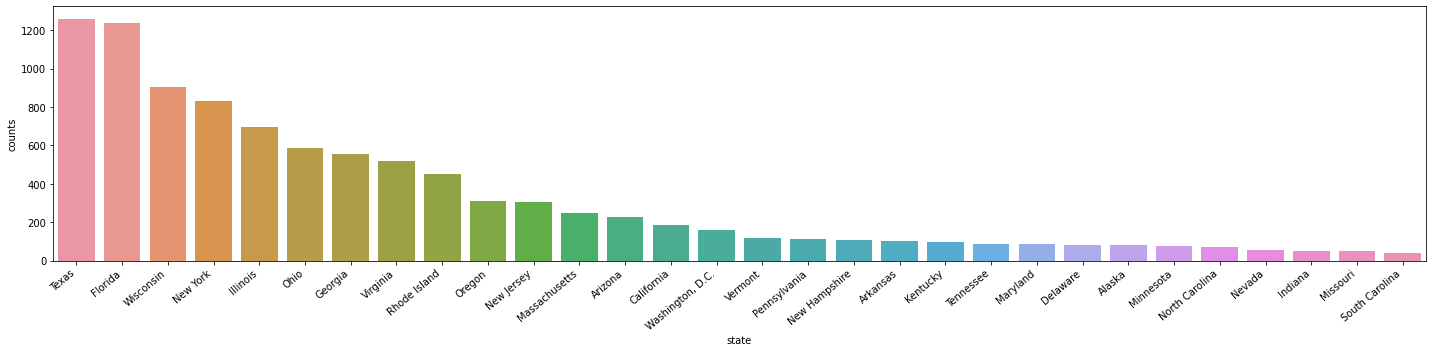

In [ ]:
# Visualize the distribution of states besides missing with seaborn
clean_state = fakenews['state'].value_counts().rename_axis('state').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
state_to_visualize = clean_state.loc[clean_state['state']!='missing'][0:30]

plt.figure(figsize=(20,5))
l = sns.barplot(x="state", y="counts", data=state_to_visualize)
l.set_xticklabels(l.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

#### Speaker Party

This part examines the "party" variable in the dataset, which has the parties that speakers belong to. The distribution shows that while the majority of the speakers are republican or democrat, a much smaller number of speakers come from various other smaller parties like the independent party or have no party affiliation. To normalize the party feature, I ranamed all the parties besides republican and democrat to "other parties". The plot of the distribution shows that the distribution of parties became more even after the adjustment. 

In [ ]:
# Distribution of parties
party = fakenews['party'].value_counts().rename_axis('party').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
party

,party,counts
0,republican,5665
1,democrat,4137
2,none,2181
3,organization,264
4,independent,180
5,newsmaker,64
6,libertarian,51
7,journalist,49
8,activist,45
9,columnist,44


In [ ]:
# Renaming all other parties besides "republican" and "democrat" to normalize the feature
fakenews['party'] = fakenews['party'].apply(lambda x: "other parties" if (x!="republican") & (x!="democrat") else x)

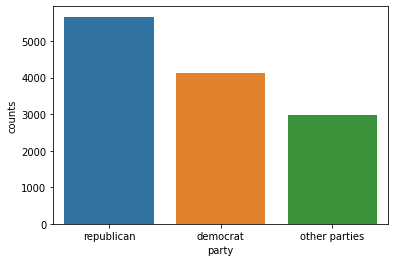

In [ ]:
# Visualize the distribution of parties after renaming with seaborn
clean_party = fakenews['party'].value_counts().rename_axis('party').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
l = sns.barplot(x="party", y="counts", data=clean_party)

plt.show()

#### Statement Context

This part examines the "context" variable in the dataset, which has the context of statements. The distribution of the variable shows that while news release, interviews and press release each has around 300 statements, the overwhelming majority of the contexts only have one statement. Still, I decided to use the "context" variable as a feature because the contexts of the statements may have impact on their truth values. A statement from press release, for example, might be more truthful than a statement from Tweet.


In [ ]:
# Distribution of contexts
context = fakenews['context'].value_counts().rename_axis('context').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
context

,context,counts
0,a news release,309
1,an interview,286
2,a press release,282
3,a speech,259
4,a TV ad,222
...,...,...
2515,a TV interview on WFLA,1
2516,a political mailer,1
2517,a forum on cancer organized by Lance Armstrong.,1
2518,"an interview on WOR 710-AM's ""The John Gamblin...",1


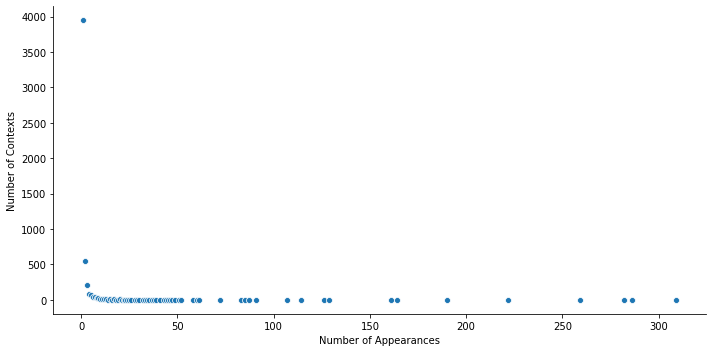

In [ ]:
# Distribution of the counts of contexts
context_counts = context.groupby('counts', as_index = False).count()
context_counts.columns = ['Number of Appearances', 'Number of Contexts']
m = sns.relplot(x = 'Number of Appearances', y = 'Number of Contexts', kind="scatter", data = context_counts, height=5, aspect=2)

#### Credit History

This part examines the credit history variables in the dataset that record the truth values of the past statements of the speaker, including "barely_true", "not_true",	"half_true", "mostly_true" and "lie". The boxplot below shows that while the distribution of these truth values are relatively similar, politicians tell fewer lies but more not true (false) statements. I will use these credit history variables as features because the history of a politician telling truth and lies may have important indications regarding whether this politician will tell truth in future statements. 

I also plot the correlations among the truth values of these statements to explore how these truth values correlate with each other. The result shows that while "barely true", "not_true", "half_true", and "mostly_true" have relatively strong correlations with each other (0.7-0.8), "lie" has different level of correlations with the rest. Among all truth values, "lie" is most strongly correlated with "not_true" (around 0.7) and moderately strongly correlated with "barely true" (around 0.5). It is not correlated with "half_true" and "mostly_true".

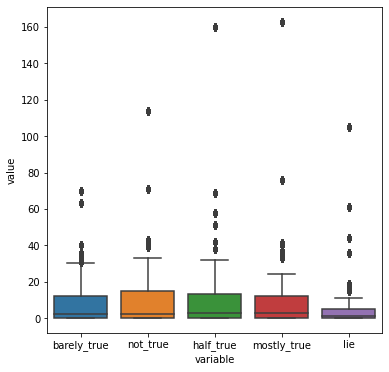

In [ ]:
# Boxplot of credit history with seaborn
plt.figure(figsize=(6,6))

credit_history = fakenews[['barely_true', 'not_true', 'half_true', 'mostly_true', 'lie']]
credit_history = pd.melt(credit_history)
sns.boxplot(x='variable', y='value', data=credit_history)

plt.show()

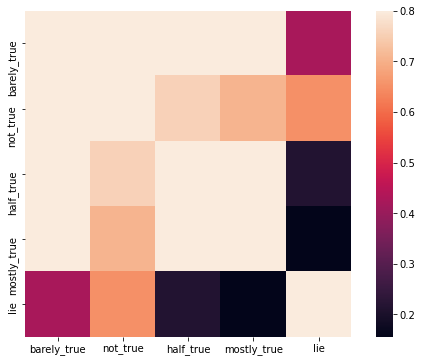

In [ ]:
# Correlations among different truth values in credit history
correlation = fakenews[['barely_true', 'not_true', 'half_true', 'mostly_true', 'lie']]
corrmat = correlation.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, vmax=.8, square=True)

### Label

This part explores the labels for predictions. There are six different labels provided by the dataset in the "label" column to represent the truth value of a statement, they are "half-true", "FALSE", "mostly-true", "barely-true", "TRUE", and "pants-fire" (lie). Their distribution, as shown below, is relatively even, with "pants_fire" having the least counts. I will use these six labels for predictions in the machine learning model. 

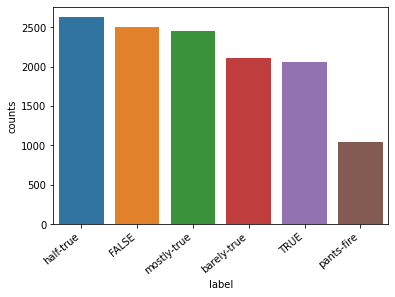

In [ ]:
# Plotting the distribution of six labels using seaborn
label = fakenews['label'].value_counts().rename_axis('label').reset_index(name = 'counts').sort_values(by='counts', ascending = False)

l = sns.barplot(x="label", y="counts", data=label)
l.set_xticklabels(l.get_xticklabels(), rotation=40, ha="right")

plt.show()

However, considering the difficulties of predicting six labels, I also created a new column "label2" to classify these six labels into two categories to observe the subsequent changes in model performance. A statement will be labeled as 1 if its label is “true”, “mostly-true”, and “half-true” because they are closer to truth, and a statement will be labeled as 0 if its label is ‘barely-true”, “false”, and “pants-fire”. The distribution of "label2", as shown below, is also relatively even. I will use these two labels for predictions in the machine learning model as well.  


In [ ]:
# Create binary labels, name the new label column "label2"
fakenews['label2'] = fakenews['label'].map(lambda x: 1 if x in ['TRUE', 'mostly-true', 'half-true'] else 0)

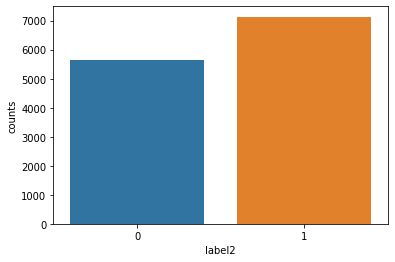

In [ ]:
# Plotting the distribution of the two new labels using seaborn
label2 = fakenews['label2'].value_counts().rename_axis('label2').reset_index(name = 'counts').sort_values(by='counts', ascending = False)

m = sns.barplot(x="label2", y="counts", data=label2)
plt.show()

Finally, reset index for the final prepared dataset

In [ ]:
# The final prepared dataset
fakenews = fakenews.reset_index().drop(['index'], axis=1)
fakenews

,id,label,statement,subject,speaker,title,state,party,barely_true,not_true,half_true,mostly_true,lie,context,statement_length,statement_length_log,subject_count,label2
0,2635.json,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,state representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,82,4.406719,1,0
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,state delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,141,4.948760,3,1
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,president,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,105,4.653960,1,1
3,1123.json,FALSE,Health care reform legislation is likely to ma...,health-care,blog-posting,missing,missing,small parties,7.0,19.0,3.0,5.0,44.0,a news release,78,4.356709,1,0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,missing,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,54,3.988984,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12784,7334.json,half-true,Says his budget provides the highest state fun...,education,rick-scott,governor,Florida,republican,28.0,23.0,38.0,34.0,7.0,a news conference,82,4.406719,1,1
12785,9788.json,barely-true,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,governor,Missouri,democrat,2.0,0.0,0.0,1.0,0.0,"on ABC's ""This Week""",31,3.433987,3,0
12786,10710.json,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, foreign policy research institute",Rhode Island,small parties,1.0,0.0,0.0,0.0,0.0,a commentary in The Providence Journal,147,4.990433,4,0
12787,3186.json,barely-true,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"governor of ohio as of jan. 10, 2011",Ohio,republican,9.0,8.0,10.0,18.0,3.0,a news conference,96,4.564348,2,0


## Primary Task

The primary task of this project is to train and optimize a machine learning model to predict the truth value for statements, first for multi-class classification (six labels), then for binary classification (two labels), and to observe the differences in model performance.

### Multi-Class Classification: six labels

First, define a function to evaluate predictions after cross-validation and compare the performance of different classifiers. 

In [ ]:
# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

# Define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle)

    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.2f}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison

Then, define features with subsets and evaluate which features to use, including features related to statements, speakers, and credit history. 

In [ ]:
# Define features with different subsets
statement_features = ["subject", "subject_count", "context", "statement_length_log"]
speaker_features = ["title", "state", "party"]
credit_features = ['barely_true', 'not_true', 'half_true', 'mostly_true', 'lie']

feature_sets = {
    "statement only": statement_features,
    "speaker only": speaker_features,
    "credit only": credit_features,
    "statement and speaker": statement_features + speaker_features,
    "statement and credit": statement_features + credit_features,
    "speaker and credit": speaker_features + credit_features,
    "all features": statement_features + speaker_features + credit_features
}

# Evaluate model performace with different feature subsets using Accuracy score. 
best = 0
best_name = None

for set_name, feature_set in feature_sets.items():

    X = fakenews.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = fakenews["label"]

    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X, y)
    y_pred = model.predict(X)

    y_matches = (y_pred == y)
    accuracy = 100*accuracy_score(y, y_pred)
    if accuracy >= best:
        best = accuracy
        best_name = set_name
        

    # Bookkeeping and printing for the reader
    print(f"Feature set: {set_name}")
    print(f"   Accuracy: {accuracy:.1f}%")
    print(f"   Tree contains {model.get_n_leaves()} leaves")
    

print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")  

Feature set: statement only
   Accuracy: 99.9%
   Tree contains 8671 leaves
Feature set: speaker only
   Accuracy: 37.1%
   Tree contains 1560 leaves
Feature set: credit only
   Accuracy: 46.8%
   Tree contains 391 leaves
Feature set: statement and speaker
   Accuracy: 100.0%
   Tree contains 7747 leaves
Feature set: statement and credit
   Accuracy: 100.0%
   Tree contains 5941 leaves
Feature set: speaker and credit
   Accuracy: 47.4%
   Tree contains 1173 leaves
Feature set: all features
   Accuracy: 100.0%
   Tree contains 5845 leaves
Best feature set is: all features 
With: 100.0% accuracy.


The results above show that among all subsets of features, features related to statements, including "subject", "subject_count", "context", and "statement_length_log" are the most important for the model predictions, which achieved a 99.99% accuracy in decision trees by themselves while not addressing overfitting. The accuracy score reached 100% when statement features are used together with speaker features, statement features are used together with credit history features, and when three subsets of features are used together. 

While statement features are able to achieve a high accuracy by themselves, I still decide to use all three subsets of features together in the machine learning model because together they are able to achieve a 100% accuracy score with the least amount of leaves. 

In [ ]:
# Create feature set from all features
feature_set = statement_features + speaker_features + credit_features

# Create train/test split
X = fakenews[feature_set]
X = pd.get_dummies(X)
y = fakenews["label"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

Since the multi-class classification has six labels, I can only use decision tree classifier and random forest classifier for classification. I tried these two classifiers in the next part with 5 folds cross-validation to compare their performace. The result shows that although the accuracy score of decision tree is slightly better than random forest (38.60% compared to 38.47%), their performance are very similar. 

In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forests": RandomForestClassifier()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, fakenews, feature_set, "label", noisy = 'quiet', folds=5)

print(f"Best classifier is: {best_name} \nWith Accuracy={best:.2f}%.")   

Decision Tree: Fold 0...1...2...3...4
Average Accuracy: 38.60
-------------
Random Forests: Fold 0...1...2...3...4
Average Accuracy: 38.47
-------------
Best classifier is: Decision Tree 
With Accuracy=38.60%.


#### Decision Tree Classifier

Since the level of performance of the decision tree classifier and the random forest classifier are pretty close, I decided to tune hyperparameters for both of these two classfiers and compare their accuracy scores again after tuning.

For the decision tree classifier, I first used RandomizedSearchCV to create a For the decision tree classifier hyperparameter tuning, I first used RandomizedSearchCV to create a parameter grid to sample from during fitting, because it allows selecting at random to sample a wide range of hyperparameter values instead of trying every single combination. I set the number of iterations (n_iter) to 60 and the number of folds for cross validation (cv) to 5, because as much as I want to cover wider search space and reduce the chance of overfitting, I need to make sure the run time is reasonable. The hyperparameters to tune include:

* criterion: function to measure the quality of a split, including gini and entropy.
* min_impurity_decrease: a node will be split if this split induces a decrease of the
impurity greater than or equal to this value.
* min_samples_split: the min number of samples required to split an internal node
* max_depth: the maximum depth of the tree.
* min_samples_leaf: the min number of samples required to be at a leaf node.

The best random search model returns a 40.54% accuracy on the test set, which has a 1.94% increase compared with the decision tree model before tuning. The best hyperparameters are:


* criterion = "gini"
* min_impurity_decrease = 0.0001
* max_depth = 25
* min_samples_leaf = 0.01
* min_samples_split = 0.001


In [ ]:
# Use RandomizedSearchCV to create a parameter grid to sample from during fitting
random_grid = {"criterion":["gini", "entropy"],
               "min_impurity_decrease":[0.0001, 0.001, 0.01],
               "max_depth": [15, 20, 25, 30, 35, 40, 45, 50],
               "min_samples_leaf": [0.001, 0.01], 
               "min_samples_split": [0.001, 0.01]
}

dt_random = RandomizedSearchCV(estimator = DecisionTreeClassifier(), param_distributions = random_grid, n_iter = 60, cv = 5, random_state=123)

# Train a classifier with each combination of hyperparameters and take the best one and print out the results
classifier = dt_random.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.2f}%")

Best fit when training was DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=25, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=0.001,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
With 43.0% accuracy.
Accuracy on held-out test set: 40.54%


The result from random search allows me to narrow down the range of values for each hyperparameter. I then used GridSearchCV to specify the best values and evaluate all combinations to further improve model performance. I still set the number of folds for cross validation (cv) to 5. The best grid search model returns a 40.54% accuracy on the test set, which is the same as the last time. The best hyperparameters are:

* criterion = "gini"
* min_impurity_decrease = 0.0001
* max_depth = 20
* min_samples_leaf = 0.01
* min_samples_split = 0.001

In [ ]:
# Decide on the hyperparameters we would like to compare
hyperparameters = {
    "criterion":["gini"],
    "min_impurity_decrease":[0.0001, 0.001],
    "max_depth": [20, 25, 30],
    "min_samples_leaf": [0.01, 0.02], 
    "min_samples_split": [0.001, 0.002]
}

# Decide on number of folds for cross validation in the hyerparameter search
kfolds = 5

# Initialize a search using cross validation in GridSearchCV
search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                            param_grid=hyperparameters, cv=kfolds, scoring="accuracy")

# Train a classifier with each combination of hyperparameters and take the best one and print out the results
classifier = search.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.2f}%")

Best fit when training was DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=0.001,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
With 43.0% accuracy.
Accuracy on held-out test set: 40.54%


#### Random Forest Classifier

For the random forest classifier hyperparameter tuning, I also first used RandomizedSearchCV with 60 iterations and 5 folds for cross validation. The hyperparameters to tune include:


*   n_estimators: the number of trees in the forest.
*   max_depth: the maximum depth of the tree. 
*   max_features: the number of features to consider when looking for the best split
*   min_samples_leaf: the minimum number of samples required to be at a leaf node.
*   min_samples_split: the minimum number of samples required to split an internal node

The best random search model returns a 39.05% accuracy on the test set, which has a 0.58% increase compared with the random forest model before tuning. The best hyperparameters are:
* n_estimators = 90
* max_depth = 45
* max_features = 'sqrt'
* min_samples_split= 5
* min_samples_leaf = 1







In [ ]:
# Use RandomizedSearchCV to create a parameter grid to sample from during fitting
random_grid = {'n_estimators': [60, 70, 80, 90, 100, 110, 120],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [20, 25, 30, 35, 40, 45, 50, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 80, cv = 5, random_state=123)

# Train a classifier with each combination of hyperparameters and take the best one and print out the results
classifier = rf_random.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.2f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.2f}%")

Best fit when training was RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=45, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
With 41.89% accuracy.
Accuracy on held-out test set: 39.05%


I then used GridSearchCV to specify to further improve model performance with 5 folds for cross validation. The best grid search model returns a 40.3% accuracy on the test set, which has a 1.25% improvement compared with the last optimization. The best hyperparameters are:
* n_estimators = 70
* max_depth = 35
* max_features = 'auto'
* min_samples_split= 2
* min_samples_leaf = 2

In [ ]:
# Decide on the hyperparameters we would like to compare
hyperparameters = {
    'n_estimators': [70, 80, 90, 100],
    "max_depth": [35, 40, 45, 50],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5]
}

# Decide on number of folds for cross validation in the hyerparameter search
kfolds = 5

# Initialize a search using cross validation in GridSearchCV
search = GridSearchCV(estimator=RandomForestClassifier(random_state=123),
                            param_grid=hyperparameters, cv=kfolds, scoring="accuracy")

# Train a classifier with each combination of hyperparameters and take the best one and print out the results
classifier = search.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.1f}%")

Best fit when training was RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=35, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
With 41.2% accuracy.
Accuracy on held-out test set: 40.3%


### Binary Classification: two labels

Define features with subsets and evaluate which features to use, including features related to statements, speakers, and credit history.

In [ ]:
# Define features with different subsets
statement_features = ["subject", "subject_count", "context", "statement_length_log"]
speaker_features = ["title", "state", "party"]
credit_features = ['barely_true', 'not_true', 'half_true', 'mostly_true', 'lie']

feature_sets = {
    "statement only": statement_features,
    "speaker only": speaker_features,
    "credit only": credit_features,
    "statement and speaker": statement_features + speaker_features,
    "statement and credit": statement_features + credit_features,
    "speaker and credit": speaker_features + credit_features,
    "all features": statement_features + speaker_features + credit_features
}

# Evaluate model performace with different feature subsets using Accuracy score. 
best = 0
best_name = None

for set_name, feature_set in feature_sets.items():

    X = fakenews.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = fakenews["label2"]

    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X, y)
    y_pred = model.predict(X)

    y_matches = (y_pred == y)
    accuracy = 100*accuracy_score(y, y_pred)
    if accuracy >= best:
        best = accuracy
        best_name = set_name
        

    # Bookkeeping and printing for the reader
    print(f"Feature set: {set_name}")
    print(f"   Accuracy: {accuracy:.1f}%")
    print(f"   Tree contains {model.get_n_leaves()} leaves")
    

print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")  

Feature set: statement only
   Accuracy: 99.9%
   Tree contains 5219 leaves
Feature set: speaker only
   Accuracy: 67.2%
   Tree contains 1341 leaves
Feature set: credit only
   Accuracy: 73.8%
   Tree contains 377 leaves
Feature set: statement and speaker
   Accuracy: 100.0%
   Tree contains 4298 leaves
Feature set: statement and credit
   Accuracy: 100.0%
   Tree contains 3027 leaves
Feature set: speaker and credit
   Accuracy: 74.0%
   Tree contains 897 leaves
Feature set: all features
   Accuracy: 100.0%
   Tree contains 3036 leaves
Best feature set is: all features 
With: 100.0% accuracy.


The results again show that among all the subsets, features related to statements are the most useful for model prediction, which achieved a 99.99% accuracy compared with 67.2% for speaker features and 73.8% for credit features. The accuracy score reached 100% when statement features are used together with speaker features, credit features, and when three subsets of features are used together. Due to the same reason as above and for a better comparison with multi-class classification, I still used all three subsets of features.

In [ ]:
# Create feature set from all features
feature_set = statement_features + speaker_features + credit_features

# Create train/test split
X = fakenews[feature_set]
X = pd.get_dummies(X)
y = fakenews["label2"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

I first tried decision tree classifier and random forest classifier with 5 folds cross- validation to compare their performances. The result shows that in the absence of hyperparameter tuning, the accuracy score of random forests is only slightly better than decision tree (69.44% compared with 67.78%). Thus, I had to tune hyperparameters for both and compare their performances again after adjusting. However, it is worth noticing that the accuracy of both classifiers already improved greatly compared with multi-class classification (40.5% for decision tree and 40.3% for random forest after tuning), which means reducing the number of labels for prediction can improve model performance.


In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forests": RandomForestClassifier()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, fakenews, feature_set, "label2", noisy = 'quiet', folds=5)

print(f"Best classifier is: {best_name} \nWith Accuracy={best:.2f}%.")   

Decision Tree: Fold 0...1...2...3...4
Average Accuracy: 67.78
-------------
Random Forests: Fold 0...1...2...3...4
Average Accuracy: 69.44
-------------
Best classifier is: Random Forests 
With Accuracy=69.44%.


#### Decision Tree Classifier

For the decision tree classifier hyperparameter tuning, I first used Randomized- SearchCV with 60 iterations and 5 folds cross validation to sample a wide range of hyperparameter values. The hyperparameters to tune are the same as the decision tree for multi-class classification. The best random search model returns a 69.59 % accuracy on the test set, which has a 1.81% increase compared with the decision tree before tuning. The best hyperparameters are:

* criterion = "gini"
* min_impurity_decrease = 0.001
* max_depth = 30
* min_samples_leaf = 0.001
* min_samples_split = 0.001

In [ ]:
# Use RandomizedSearchCV to create a parameter grid to sample from during fitting
random_grid = {"criterion":["gini", "entropy"],
               "min_impurity_decrease":[0.0001, 0.001, 0.01],
               "max_depth": [10, 15, 20, 25, 30, 35, 40, 45, 50],
               "min_samples_leaf": [0.001, 0.01], 
               "min_samples_split": [0.001, 0.01]
}

dt_random = RandomizedSearchCV(estimator = DecisionTreeClassifier(), param_distributions = random_grid, n_iter = 60, cv = 5, random_state=123)

# Train a classifier with each combination of hyperparameters and take the best one and print out the results
classifier = dt_random.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.2f}%")

Best fit when training was DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=0.001, min_samples_split=0.001,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
With 71.8% accuracy.
Accuracy on held-out test set: 69.59%


I then used GridSearchCV with 5 folds for cross validation to specify the best values and evaluate all combinations to further improve model performance. The best grid search model returns a 69.59% accuracy score on the test set, which is the same as the result of best random search. It seems that the performance has reached its best. The best hyperparameters are:
* criterion = "gini"
* min_impurity_decrease = 0.001
* max_depth = 25
* min_samples_leaf = 0.001
* min_samples_split = 0.001

In [ ]:
# Decide on the hyperparameters we would like to compare
hyperparameters = {
    "criterion":["gini"],
    "min_impurity_decrease":[0.0001, 0.001],
    "max_depth": [25, 30, 35],
    "min_samples_leaf": [0.001, 0.002], 
    "min_samples_split": [0.001, 0.002]
}

# Decide on number of folds for cross validation in the hyerparameter search
kfolds = 5

# Initialize a search using cross validation in GridSearchCV
search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                            param_grid=hyperparameters, cv=kfolds, scoring="accuracy")

# Train a classifier with each combination of hyperparameters and take the best one and print out the results
classifier = search.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.2f}%")

Best fit when training was DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=25, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=0.001, min_samples_split=0.001,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
With 71.8% accuracy.
Accuracy on held-out test set: 69.59%


#### Random Forest Classifier

For the random forest classifier hyperparameter tuning, I first used Randomized- SearchCV with 80 iterations and 5 folds for cross validation. The hyperparameters to tune are the same as the random forest for multi-class classification. The best random search model returns a 69.78% accuracy on the test set, which has a 0.34% increase compared with the random forest model before tuning. The best hyperparameters are:
* n_estimators = 160
* max_depth = 80
* max_features = 'sqrt'
* min_samples_split= 8
* min_samples_leaf = 1

In [ ]:
# Use RandomizedSearchCV to create a parameter grid to sample from during fitting
random_grid = {'n_estimators': [80, 90, 100, 110, 120, 130, 140, 150, 160],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [50, 55, 60, 65, 70, 75, 80, 85, 90, None],
               'min_samples_split': [2, 4, 8],
               'min_samples_leaf': [1, 2, 4]
               }

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 5, random_state=123)

# Train a classifier with each combination of hyperparameters and take the best one and print out the results
classifier = rf_random.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.2f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.2f}%")

Best fit when training was RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=160,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
With 71.57% accuracy.
Accuracy on held-out test set: 69.78%


I then used GridSearchCV with 5 folds for cross validation to specify the best values and evaluate all combinations to further improve model performance. The best grid search model returns a 70.3% accuracy score on the test set, which has a 0.52% improvement compared with the result from random search.
The best hyperparameters are:
* n_estimators = 150
* max_depth = 65
* max_features = 'auto’
* min_samples_split= 8
* min_samples_leaf = 1

In [ ]:
# Decide on the hyperparameters we would like to compare
hyperparameters = {
    'n_estimators': [150, 160, 170],
    "max_depth": [60, 65, 70, 75, 80, 85, 90],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [8, 10]
}

# Decide on number of folds for cross validation in the hyerparameter search
kfolds = 5

# Initialize a search using cross validation in GridSearchCV
search = GridSearchCV(estimator=RandomForestClassifier(random_state=123),
                            param_grid=hyperparameters, cv=kfolds, scoring="accuracy")

# Train a classifier with each combination of hyperparameters and take the best one and print out the results
classifier = search.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.1f}%")

Best fit when training was RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=65, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
With 71.5% accuracy.
Accuracy on held-out test set: 70.3%


### Final Model: Random Forest predicting binary labels

#### Performance Evaluation


I select random forest classifier for binary classification as my final model because it has the best performance. Its tuned hyperparameters are as follows:
* n_estimators = 150
* max_depth = 65
* max_features = 'auto’
* min_samples_split= 8
* min_samples_leaf = 1

I trained the final model again using 10-fold cross validation. The model achieved a 71.3% mean accuracy score across 10 folds and a 70% accuracy on the test set.

In [ ]:
# Create feature set from all features
feature_set = statement_features + speaker_features + credit_features

# Create train/test split
X = fakenews[feature_set]
X = pd.get_dummies(X)
y = fakenews["label2"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

In [ ]:
# random forest model creation
rfc = RandomForestClassifier(n_estimators=150, max_depth=65, max_features="auto", min_samples_leaf=1, min_samples_split=8, random_state=123)
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')

# print out performace
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All Accuracy Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean Accuracy Score ===")
print("Mean accuracy Score - Random Forest: ", rfc_cv_score.mean())
print('\n')
print("=== Accuracy Score on the test set ===")
print("Final accuracy Score on the test set - Random Forest:", 100*accuracy_score(y_test, rfc_predict)

=== Confusion Matrix ===
[[ 587  565]
 [ 194 1212]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.51      0.61      1152
           1       0.68      0.86      0.76      1406

    accuracy                           0.70      2558
   macro avg       0.72      0.69      0.68      2558
weighted avg       0.71      0.70      0.69      2558



=== All Accuracy Scores ===
[0.71618452 0.72947615 0.71540266 0.71774824 0.69194683 0.71383894
 0.70992963 0.71149335 0.71540266 0.71048513]


=== Mean Accuracy Score ===
Mean accuracy Score - Random Forest:  0.713190811972871


A closer examination of the confusion matrix shows that the final model is better at predicting truth values (1) than false values (0). Most noticeably, as shown in Figure 17, the model only had around 50% accuracy when predicting false values.

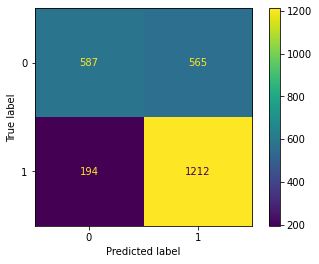

In [ ]:
# Generate confusion matrix with scikit-learn
predictions = rfc_predict
actual = np.array(list(y_test))

conf_matrix = confusion_matrix(actual, predictions)
ConfusionMatrixDisplay(conf_matrix, ["0", "1"]).plot(values_format='.4g')
plt.show()

#### Error Analysis

To have a better understanding of where my model made mistakes, I further examined the distribution of six truth values among right and wrong predictions. The result shows that among labels in the wrong predictions, there are disproportionately more barely- true and false values than other values compared with distribution in right predictions, meaning the model is weaker at predicting these two types of statements.

In [ ]:
# Combine test labels with features and predictions
test_result = fakenews.loc[X_test.index, :]
test_result['prediction'] = rfc_predict

In [ ]:
# Separate the dataframe according to right and wrong predictions
right_prediction = test_result.loc[test_result['label2']==test_result['prediction']]
wrong_prediction = test_result.loc[test_result['label2']!=test_result['prediction']]

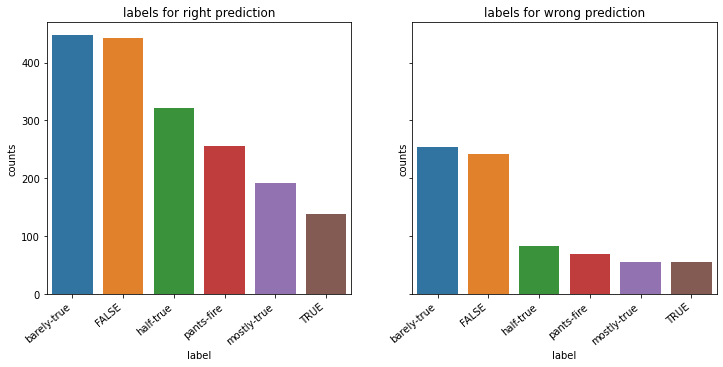

In [ ]:
# Plot the distribution of six truth values in right and wrong predictions
right_labels = right_prediction['label'].value_counts().rename_axis('label').reset_index(name = 'counts').sort_values(by='counts', ascending = False)
wrong_labels = wrong_prediction['label'].value_counts().rename_axis('label').reset_index(name = 'counts').sort_values(by='counts', ascending = False)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
ax1.set_title('labels for right prediction')
ax2.set_title('labels for wrong prediction')

a = sns.barplot(x="label", y="counts", data=right_labels, ax=ax1)
a.set_xticklabels(l.get_xticklabels(), rotation=40, ha="right")
b = sns.barplot(x="label", y="counts", data=wrong_labels, ax=ax2)
b.set_xticklabels(l.get_xticklabels(), rotation=40, ha="right")

plt.show()


I also examined the distribution of top 10 subjects among right and wrong predictions to see what subjects have the most errors. As shown in figure 19, subjects including health care, taxes, education, and elections have proportional distributions, which means that the classifier is equally good at predicting those subjects. However, the classifier is weaker at predicting immigration, economy, crime, and transportation.

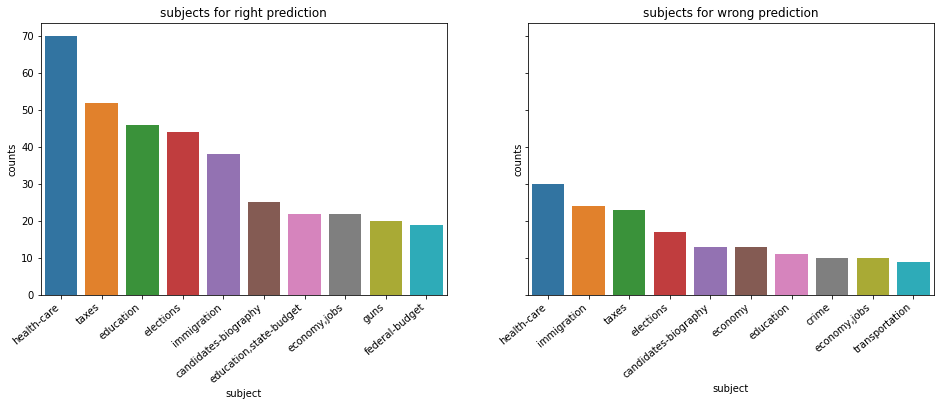

In [ ]:
# Plot the distribution of subjects in right and wrong predictions
right_subjects = right_prediction['subject'].value_counts().rename_axis('subject').reset_index(name = 'counts').sort_values(by='counts', ascending = False)[0:10]
wrong_subjects = wrong_prediction['subject'].value_counts().rename_axis('subject').reset_index(name = 'counts').sort_values(by='counts', ascending = False)[0:10]

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16,5))
ax1.set_title('subjects for right prediction')
ax2.set_title('subjects for wrong prediction')

c = sns.barplot(x="subject", y="counts", data=right_subjects, ax=ax1)
c.set_xticklabels(c.get_xticklabels(), rotation=40, ha="right")
d = sns.barplot(x="subject", y="counts", data=wrong_subjects, ax=ax2)
d.set_xticklabels(d.get_xticklabels(), rotation=40, ha="right")

plt.show()


Finally, I examined the distribution of top 10 contexts among right and wrong predictions to see in what contexts my classifier is weaker at predicting. The result shows that while my classifier is good at predicting a press release, a news release, and a speech, it is worse at predicting an interview, a TV ad, a debate, and a Facebook post.

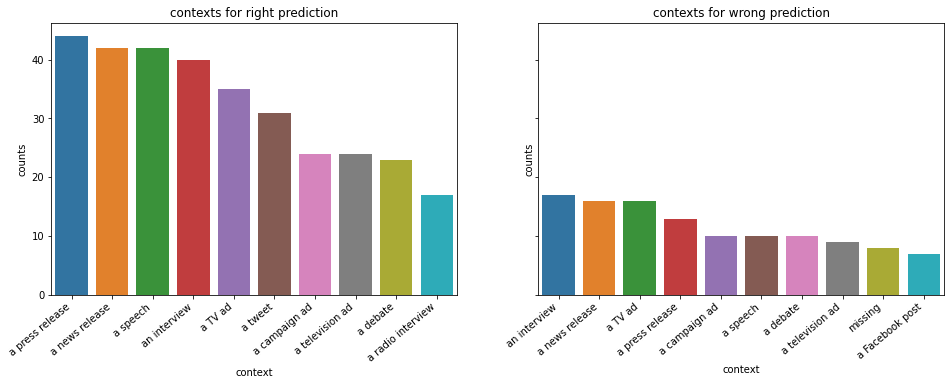

In [ ]:
# Plot the distribution of contexts in right and wrong predictions
right_contexts = right_prediction['context'].value_counts().rename_axis('context').reset_index(name = 'counts').sort_values(by='counts', ascending = False)[0:10]
wrong_contexts = wrong_prediction['context'].value_counts().rename_axis('context').reset_index(name = 'counts').sort_values(by='counts', ascending = False)[0:10]

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16,5))
ax1.set_title('contexts for right prediction')
ax2.set_title('contexts for wrong prediction')

g = sns.barplot(x="context", y="counts", data=right_contexts, ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")
h = sns.barplot(x="context", y="counts", data=wrong_contexts, ax=ax2)
h.set_xticklabels(h.get_xticklabels(), rotation=40, ha="right")

plt.show()

## Extension Task

The extension task of this project conducts a fairness audit on the classifier by separating out statements by political party to measure and describe bias of the classifier by party. I only included the Republican party and the Democratic party in the audit because they are the two largest parties in the United States, and they have the most data entries in the dataset. Small parties are excluded from the fairness audit because there are too many of them and they have fewer data entries. The classifier used is the final optimized random forest classifier.


The results of the following functions show that while the false positive rate of the classifier is 31.8%, the false negative rate is only 24.8%

In [ ]:
# Calculating false positive rate
false_positive = test_result.loc[(test_result['prediction']==1) & (test_result['label2']==0)]
false_positive_rate = len(false_positive) / len(test_result.loc[test_result.prediction==1])
print(f"The false positive rate for the classifer is {false_positive_rate}")

The false positive rate for the classifer is 0.31795160382667415


In [ ]:
# Calculating false negative rate
false_negative = test_result.loc[(test_result['prediction']==0) & test_result['label2']==1 ]
false_negative_rate = len(false_negative) / len(test_result.loc[test_result.prediction==0])
print(f"The false negative rate for the classifier is {false_negative_rate}")

The false negative rate for the classifier is 0.24839948783610755


A closer examination of false positive rate and false negative rate by party shows that while the false positive rate for the republican party is higher than that of the democratic party by about 10%, the false negative rate for the republicans is higher than that of the democrats by a bit more than 10%. This means that the classifier has a higher tendency to not only falsely predict a statement to be true (while it is false) for republicans than for democrats, but also falsely predict a statement to be false (while it is actually true) for republicans.


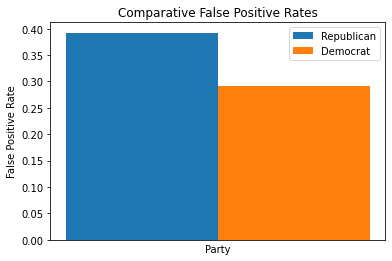

In [ ]:
# Separate dataset into republicans and democrats
republican = test_result.loc[test_result['party']=='republican']
democrat = test_result.loc[test_result['party']=='democrat']

# Error balance of false positives
party_probs = []
for party in [republican, democrat]:
  probs = []
  false_positive = party.loc[(party['prediction']==1) & (party['label2']==0)]
  false_positive_rate = len(false_positive) / len(party.loc[party.prediction==1])
  probs.append(false_positive_rate)
  party_probs.append(probs)

# Plot false positives by party
fig = plt.gcf()
plt.bar(range(1,2), party_probs[0], align='edge', width=-.1)
plt.bar(range(1,2), party_probs[1], align='edge', width=.1)
plt.xlabel("Party")
plt.xticks(ticks=range(1,2))
plt.xticks([0], ["party"])
plt.ylabel("False Positive Rate")
plt.legend(["Republican", "Democrat"])
plt.title("Comparative False Positive Rates")
plt.show()

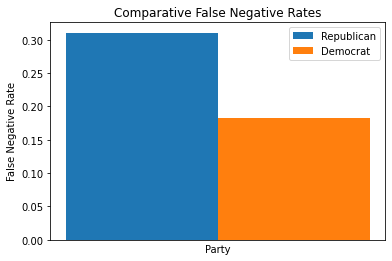

In [ ]:
# Error balance of false negatives
party_probs = []
for party in [republican, democrat]:
  probs = []
  false_positive = party.loc[(party['prediction']==0) & (party['label2']==1)]
  false_positive_rate = len(false_positive) / len(party.loc[party.prediction==0])
  probs.append(false_positive_rate)
  party_probs.append(probs)

# Plot false negatives by party
fig = plt.gcf()
plt.bar(range(1,2), party_probs[0], align='edge', width=-.1)
plt.bar(range(1,2), party_probs[1], align='edge', width=.1)
plt.xlabel("Party")
plt.xticks(ticks=range(1,2))
plt.xticks([0], ["party"])
plt.ylabel("False Negative Rate")
plt.legend(["Republican", "Democrat"])
plt.title("Comparative False Negative Rates")
plt.show()

To further explore the reasons that contribute to the discrepancy in false negative rates, I examined the distribution of the two parties and the binary labels in the dataset. While there is an equal distribution of truth and false statements for the Republican party, the number of truth statements far exceeds the number of false statements for the Democratic party. This indicates that the dataset itself is biased against the Republican party by including more false statements of republicans than democrats, which could contribute to the unfairness of the classifier.

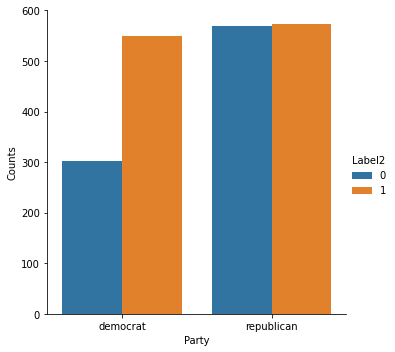

In [ ]:
# Plot the distribution of parties and label2 in test data
party_values = test_result.groupby(['party', 'label2'], as_index = False).count()[['party', 'label2', 'id']].sort_values(by='id')
party_values = party_values.loc[party_values['party']!='small parties']
party_values.columns = ['Party', 'Label2', 'Counts']

k = sns.catplot(x="Party", y="Counts", kind='bar', hue='Label2', data=party_values)